# AutoGluon para classificação de texto multilabel

José Augusto de Almeida Neto

## Instalar AutoGluon e Importar bibliotecas

In [1]:
!pip install autogluon

ERROR: Ignored the following versions that require a different python version: 0.1.0 Requires-Python >=3.6, <3.9; 0.1.0b20210207 Requires-Python >=3.6, <3.8; 0.1.0b20210208 Requires-Python >=3.6, <3.8; 0.1.0b20210209 Requires-Python >=3.6, <3.8; 0.1.0b20210210 Requires-Python >=3.6, <3.8; 0.1.0b20210211 Requires-Python >=3.6, <3.8; 0.1.0b20210212 Requires-Python >=3.6, <3.8; 0.1.0b20210213 Requires-Python >=3.6, <3.8; 0.1.0b20210214 Requires-Python >=3.6, <3.8; 0.1.0b20210215 Requires-Python >=3.6, <3.8; 0.1.0b20210216 Requires-Python >=3.6, <3.8; 0.1.0b20210217 Requires-Python >=3.6, <3.8; 0.1.0b20210218 Requires-Python >=3.6, <3.8; 0.1.0b20210219 Requires-Python >=3.6, <3.8; 0.1.0b20210220 Requires-Python >=3.6, <3.8; 0.1.0b20210221 Requires-Python >=3.6, <3.8; 0.1.0b20210222 Requires-Python >=3.6, <3.8; 0.1.0b20210223 Requires-Python >=3.6, <3.8; 0.1.0b20210224 Requires-Python >=3.6, <3.8; 0.1.0b20210225 Requires-Python >=3.6, <3.9; 0.1.0b20210226 Requires-Python >=3.6, <3.9; 0.1.0b

In [2]:
import time
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from autogluon.tabular import TabularDataset, TabularPredictor
from autogluon.common.utils.utils import setup_outputdir
from autogluon.core.utils.loaders import load_pkl
from autogluon.core.utils.savers import save_pkl
import os.path

## Classe MultilabelPredictor e definição de parâmetros

In [3]:
# Definir a classe MultilabelPredictor personalizada para gerenciar uma coleção de objetos TabularPredictor, um para cada rótulo. 
class MultilabelPredictor():
    """ Tabular Predictor for predicting multiple columns in table.
        Creates multiple TabularPredictor objects which you can also use individually.
        You can access the TabularPredictor for a particular label via: `multilabel_predictor.get_predictor(label_i)`

        Parameters
        ----------
        labels : List[str]
            The ith element of this list is the column (i.e. `label`) predicted by the ith TabularPredictor stored in this object.
        path : str, default = None
            Path to directory where models and intermediate outputs should be saved.
            If unspecified, a time-stamped folder called "AutogluonModels/ag-[TIMESTAMP]" will be created in the working directory to store all models.
            Note: To call `fit()` twice and save all results of each fit, you must specify different `path` locations or don't specify `path` at all.
            Otherwise files from first `fit()` will be overwritten by second `fit()`.
            Caution: when predicting many labels, this directory may grow large as it needs to store many TabularPredictors.
        problem_types : List[str], default = None
            The ith element is the `problem_type` for the ith TabularPredictor stored in this object.
        eval_metrics : List[str], default = None
            The ith element is the `eval_metric` for the ith TabularPredictor stored in this object.
        consider_labels_correlation : bool, default = True
            Whether the predictions of multiple labels should account for label correlations or predict each label independently of the others.
            If True, the ordering of `labels` may affect resulting accuracy as each label is predicted conditional on the previous labels appearing earlier in this list (i.e. in an auto-regressive fashion).
            Set to False if during inference you may want to individually use just the ith TabularPredictor without predicting all the other labels.
        kwargs :
            Arguments passed into the initialization of each TabularPredictor.

    """

    multi_predictor_file = 'multilabel_predictor.pkl'

    def __init__(self, labels, path=None, problem_types=None, eval_metrics=None, consider_labels_correlation=True, **kwargs):
        if len(labels) < 2:
            raise ValueError("MultilabelPredictor is only intended for predicting MULTIPLE labels (columns), use TabularPredictor for predicting one label (column).")
        if (problem_types is not None) and (len(problem_types) != len(labels)):
            raise ValueError("If provided, `problem_types` must have same length as `labels`")
        if (eval_metrics is not None) and (len(eval_metrics) != len(labels)):
            raise ValueError("If provided, `eval_metrics` must have same length as `labels`")
        self.path = setup_outputdir(path, warn_if_exist=False)
        self.labels = labels
        self.consider_labels_correlation = consider_labels_correlation
        self.predictors = {}  # key = label, value = TabularPredictor or str path to the TabularPredictor for this label
        if eval_metrics is None:
            self.eval_metrics = {}
        else:
            self.eval_metrics = {labels[i] : eval_metrics[i] for i in range(len(labels))}
        problem_type = None
        eval_metric = None
        for i in range(len(labels)):
            label = labels[i]
            path_i = self.path + "Predictor_" + label
            if problem_types is not None:
                problem_type = problem_types[i]
            if eval_metrics is not None:
                eval_metric = eval_metrics[i]
            self.predictors[label] = TabularPredictor(label=label, problem_type=problem_type, eval_metric=eval_metric, path=path_i, **kwargs)

    def fit(self, train_data, tuning_data=None, **kwargs):
        """ Fits a separate TabularPredictor to predict each of the labels.

            Parameters
            ----------
            train_data, tuning_data : str or autogluon.tabular.TabularDataset or pd.DataFrame
                See documentation for `TabularPredictor.fit()`.
            kwargs :
                Arguments passed into the `fit()` call for each TabularPredictor.
        """
        if isinstance(train_data, str):
            train_data = TabularDataset(train_data)
        if tuning_data is not None and isinstance(tuning_data, str):
            tuning_data = TabularDataset(tuning_data)
        train_data_og = train_data.copy()
        if tuning_data is not None:
            tuning_data_og = tuning_data.copy()
        else:
            tuning_data_og = None
        save_metrics = len(self.eval_metrics) == 0
        for i in range(len(self.labels)):
            label = self.labels[i]
            predictor = self.get_predictor(label)
            if not self.consider_labels_correlation:
                labels_to_drop = [l for l in self.labels if l != label]
            else:
                labels_to_drop = [self.labels[j] for j in range(i+1, len(self.labels))]
            train_data = train_data_og.drop(labels_to_drop, axis=1)
            if tuning_data is not None:
                tuning_data = tuning_data_og.drop(labels_to_drop, axis=1)
            print(f"Fitting TabularPredictor for label: {label} ...")
            predictor.fit(train_data=train_data, tuning_data=tuning_data, **kwargs)
            self.predictors[label] = predictor.path
            if save_metrics:
                self.eval_metrics[label] = predictor.eval_metric
        self.save()

    def predict(self, data, **kwargs):
        """ Returns DataFrame with label columns containing predictions for each label.

            Parameters
            ----------
            data : str or autogluon.tabular.TabularDataset or pd.DataFrame
                Data to make predictions for. If label columns are present in this data, they will be ignored. See documentation for `TabularPredictor.predict()`.
            kwargs :
                Arguments passed into the predict() call for each TabularPredictor.
        """
        return self._predict(data, as_proba=False, **kwargs)

    def predict_proba(self, data, **kwargs):
        """ Returns dict where each key is a label and the corresponding value is the `predict_proba()` output for just that label.

            Parameters
            ----------
            data : str or autogluon.tabular.TabularDataset or pd.DataFrame
                Data to make predictions for. See documentation for `TabularPredictor.predict()` and `TabularPredictor.predict_proba()`.
            kwargs :
                Arguments passed into the `predict_proba()` call for each TabularPredictor (also passed into a `predict()` call).
        """
        return self._predict(data, as_proba=True, **kwargs)

    def evaluate(self, data, **kwargs):
        """ Returns dict where each key is a label and the corresponding value is the `evaluate()` output for just that label.

            Parameters
            ----------
            data : str or autogluon.tabular.TabularDataset or pd.DataFrame
                Data to evalate predictions of all labels for, must contain all labels as columns. See documentation for `TabularPredictor.evaluate()`.
            kwargs :
                Arguments passed into the `evaluate()` call for each TabularPredictor (also passed into the `predict()` call).
        """
        data = self._get_data(data)
        eval_dict = {}
        for label in self.labels:
            print(f"Evaluating TabularPredictor for label: {label} ...")
            predictor = self.get_predictor(label)
            eval_dict[label] = predictor.evaluate(data, **kwargs)
            if self.consider_labels_correlation:
                data[label] = predictor.predict(data, **kwargs)
        return eval_dict

    def save(self):
        """ Save MultilabelPredictor to disk. """
        for label in self.labels:
            if not isinstance(self.predictors[label], str):
                self.predictors[label] = self.predictors[label].path
        save_pkl.save(path=self.path+self.multi_predictor_file, object=self)
        print(f"MultilabelPredictor saved to disk. Load with: MultilabelPredictor.load('{self.path}')")

    @classmethod
    def load(cls, path):
        """ Load MultilabelPredictor from disk `path` previously specified when creating this MultilabelPredictor. """
        path = os.path.expanduser(path)
        if path[-1] != os.path.sep:
            path = path + os.path.sep
        return load_pkl.load(path=path+cls.multi_predictor_file)

    def get_predictor(self, label):
        """ Returns TabularPredictor which is used to predict this label. """
        predictor = self.predictors[label]
        if isinstance(predictor, str):
            return TabularPredictor.load(path=predictor)
        return predictor

    def _get_data(self, data):
        if isinstance(data, str):
            return TabularDataset(data)
        return data.copy()

    def _predict(self, data, as_proba=False, **kwargs):
        data = self._get_data(data)
        if as_proba:
            predproba_dict = {}
        for label in self.labels:
            print(f"Predicting with TabularPredictor for label: {label} ...")
            predictor = self.get_predictor(label)
            if as_proba:
                predproba_dict[label] = predictor.predict_proba(data, as_multiclass=True, **kwargs)
            data[label] = predictor.predict(data, **kwargs)
        if not as_proba:
            return data[self.labels]
        else:
            return predproba_dict

In [4]:
# Labels: quais colunas prever com base nas outras
labels = ['ambiente', 'bebida', 'comida', 'geral', 'localização', 'outros', 'preço', 'serviço']

# Problem type: tipo de problema da label
problem_types = ['binary'] * len(labels)

# Metrics: métricas que serão utilizadas para cada label
eval_metrics = ['f1'] * len(labels) 

## Carregar datasets

In [5]:
# Carregar dataset
df_fold1 = pd.read_csv('../../datasets/dataset-fold_1-multilabel.csv', encoding='utf-8')
df_fold2 = pd.read_csv('../../datasets/dataset-fold_2-multilabel.csv', encoding='utf-8')
df_fold3 = pd.read_csv('../../datasets/dataset-fold_3-multilabel.csv', encoding='utf-8')
df_fold4 = pd.read_csv('../../datasets/dataset-fold_4-multilabel.csv', encoding='utf-8')
df_fold5 = pd.read_csv('../../datasets/dataset-fold_5-multilabel.csv', encoding='utf-8')

In [6]:
# Gerar listas de métricas
accuracies = []
f1_score_list_macro = []
precision_list_macro = []
recall_list_macro = []
f1_score_list_micro = []
precision_list_micro = []
recall_list_micro = []

## 1° Fold

In [31]:
# Carregar dados tabulares em um objeto Dataset do PyTorch e dividir o dataset
df = pd.concat([df_fold2, df_fold3, df_fold4, df_fold5])
train_data = TabularDataset(df)
test_data = TabularDataset(df_fold1)

In [32]:
# Criar e treinar modelo
multi_predictor = MultilabelPredictor(labels=labels, problem_types=problem_types, eval_metrics=eval_metrics)
multi_predictor.fit(train_data, time_limit=600, presets='best_quality')

No path specified. Models will be saved in: "AutogluonModels/ag-20230428_062428/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20230428_062428/Predictor_ambiente/"
AutoGluon Version:  0.7.0
Python Version:     3.10.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Sat Dec 10 16:00:40 UTC 2022
Train Data Rows:    3200
Train Data Columns: 1
Label Column: ambiente
Preprocessing data ...
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    11602.17 MB
	Train Data (Original)  Memory Usage: 0.5 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes

Fitting TabularPredictor for label: ambiente ...


			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 229
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['sentenca']
		('int', ['binned', 'text_special']) :   7 | ['sentenca.char_count', 'sentenca.word_count', 'sentenca.capital_ratio', 'sentenca.lower_ratio', 'sentenca.digit_ratio', ...]
		('int', ['text_ngram'])             : 230 | ['__nlp__.acessível', '__nlp__.aconchegante', '__nlp__.agradável', '__nlp__.ainda', '__nlp__.alto', ...]
	0.9s = Fit runtime
	1 features in original data used to generate 238 features in processed data.
	Train Data (Processed) Memory Usage: 1.5 MB (0.0% of av

Fitting TabularPredictor for label: bebida ...


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 1 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 229
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 1 | ['ambiente']
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['sentenca']
		('int', ['binned', 'text_special']) :   7 

Fitting TabularPredictor for label: comida ...


			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 229
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 2 | ['ambiente', 'bebida']
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['sentenca']
		('int', ['binned', 'text_special']) :   7 | ['sentenca.char_count', 'sentenca.word_count', 'sentenca.capital_ratio', 'sentenca.lower_ratio', 'sentenca.digit_ratio', ...]
		('int', ['bool'])                   :   2 | ['ambiente', 'bebida']
		('int', ['text_ngram'])             : 230 | ['__nlp__.acessível', '__nlp__.aconchegante'

Fitting TabularPredictor for label: geral ...


			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 229
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 3 | ['ambiente', 'bebida', 'comida']
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['sentenca']
		('int', ['binned', 'text_special']) :   7 | ['sentenca.char_count', 'sentenca.word_count', 'sentenca.capital_ratio', 'sentenca.lower_ratio', 'sentenca.digit_ratio', ...]
		('int', ['bool'])                   :   3 | ['ambiente', 'bebida', 'comida']
		('int', ['text_ngram'])             : 230 | ['__nlp__.acessível', '_

Fitting TabularPredictor for label: localização ...


			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 229
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 4 | ['ambiente', 'bebida', 'comida', 'geral']
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['sentenca']
		('int', ['binned', 'text_special']) :   7 | ['sentenca.char_count', 'sentenca.word_count', 'sentenca.capital_ratio', 'sentenca.lower_ratio', 'sentenca.digit_ratio', ...]
		('int', ['bool'])                   :   4 | ['ambiente', 'bebida', 'comida', 'geral']
		('int', ['text_ngram'])             : 230 | ['__nl

Fitting TabularPredictor for label: outros ...


			Note: Converting 5 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 229
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 5 | ['ambiente', 'bebida', 'comida', 'geral', 'localização']
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['sentenca']
		('int', ['binned', 'text_special']) :   7 | ['sentenca.

Fitting TabularPredictor for label: preço ...


			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 229
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 6 | ['ambiente', 'bebida', 'comida', 'geral', 'localização', ...]
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['sentenca']
		('int', ['binned', 'text_special']) :   7 | ['sentenca.char_count', 'sentenca.word_count', 'sentenca.capital_ratio', 'sentenca.lower_ratio', 'sentenca.digit_ratio', ...]
		('int', ['bool'])                   :   6 | ['ambiente', 'bebida', 'comida', 'geral', 'localização', ...]
		('int', ['

Fitting TabularPredictor for label: serviço ...


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 7 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 229
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 7 | ['ambiente', 'bebida', 'comida', 'geral', 'localização', ...]
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['senten

MultilabelPredictor saved to disk. Load with: MultilabelPredictor.load('AutogluonModels/ag-20230428_062428/')


In [33]:
# Teste do modelo
predictions = multi_predictor.predict(test_data)

Predicting with TabularPredictor for label: ambiente ...
Predicting with TabularPredictor for label: bebida ...
Predicting with TabularPredictor for label: comida ...
Predicting with TabularPredictor for label: geral ...
Predicting with TabularPredictor for label: localização ...
Predicting with TabularPredictor for label: outros ...
Predicting with TabularPredictor for label: preço ...
Predicting with TabularPredictor for label: serviço ...


### Resultados

In [34]:
from sklearn.metrics import f1_score

# Resultados
predictions_df=pd.DataFrame(predictions) 
y_pred = predictions_df.values # Obter as previsões
y_true = test_data.drop('sentenca', axis=1).values # Obter os rótulos reais dos dados de teste

accuracy = accuracy_score(y_true, y_pred)
f1_score_macro = f1_score(y_true, y_pred, average='macro')
precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')
f1_score_micro = f1_score(y_true, y_pred, average='micro')
precision_micro = precision_score(y_true, y_pred, average='micro')
recall_micro = recall_score(y_true, y_pred, average='micro')

# Adicionar valores das métricas para lista
accuracies.append(accuracy)
f1_score_list_macro.append(f1_score_macro)
precision_list_macro.append(precision_macro)
recall_list_macro.append(recall_macro)
f1_score_list_micro.append(f1_score_micro)
precision_list_micro.append(precision_micro)
recall_list_micro.append(recall_micro)

print("Acurácia do 1° Fold:", accuracy)
print("F1 Score Macro do 1° Fold:", f1_score_macro)
print("Precisão Macro do 1° Fold:", precision_macro)
print("Revocação Macro do 1° Fold:", recall_macro)
print("F1 Score Micro do 1° Fold:", f1_score_micro)
print("Precisão Micro do 1° Fold:", precision_micro)
print("Revocação Micro do 1° Fold:", recall_micro)

Acurácia do 1° Fold: 0.61375
F1 Score Macro do 1° Fold: 0.7805979126050349
Precisão Macro do 1° Fold: 0.8066219338142889
Revocação Macro do 1° Fold: 0.7594505660408967
F1 Score Micro do 1° Fold: 0.837291740517547
Precisão Micro do 1° Fold: 0.8709439528023599
Revocação Micro do 1° Fold: 0.8061433447098976


In [35]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Calcular as métricas para cada rótulo separadamente
metrics_by_label = {}
for i, label in enumerate(labels):
    y_true_label = y_true[:, i] # Rótulos reais da classe correspondente ao label
    y_pred_label = y_pred[:, i] # Previsões da classe correspondente ao label
    accuracy = accuracy_score(y_true_label, y_pred_label)
    f1 = f1_score(y_true_label, y_pred_label)
    precision = precision_score(y_true_label, y_pred_label)
    recall = recall_score(y_true_label, y_pred_label)
    metrics_by_label[label] = {'accuracy': accuracy, 'f1_score': f1, 'precision': precision, 'recall': recall}

# Imprimir as métricas para cada rótulo
for label, metrics in metrics_by_label.items():
    print(f'Métricas para o rótulo {label}:')
    print(f'Acurácia: {metrics["accuracy"]:.4f}')
    print(f'F1-Score: {metrics["f1_score"]:.4f}')
    print(f'Precisão: {metrics["precision"]:.4f}')
    print(f'Revocação: {metrics["recall"]:.4f}')
    print('-----------------------------------')


Métricas para o rótulo ambiente:
Acurácia: 0.9012
F1-Score: 0.8371
Precisão: 0.9398
Revocação: 0.7546
-----------------------------------
Métricas para o rótulo bebida:
Acurácia: 0.9537
F1-Score: 0.7550
Precisão: 0.8261
Revocação: 0.6951
-----------------------------------
Métricas para o rótulo comida:
Acurácia: 0.8600
F1-Score: 0.8610
Precisão: 0.8943
Revocação: 0.8301
-----------------------------------
Métricas para o rótulo geral:
Acurácia: 0.8650
F1-Score: 0.7379
Precisão: 0.7379
Revocação: 0.7379
-----------------------------------
Métricas para o rótulo localização:
Acurácia: 0.9888
F1-Score: 0.8525
Precisão: 0.8387
Revocação: 0.8667
-----------------------------------
Métricas para o rótulo outros:
Acurácia: 0.9637
F1-Score: 0.3830
Precisão: 0.3600
Revocação: 0.4091
-----------------------------------
Métricas para o rótulo preço:
Acurácia: 0.9762
F1-Score: 0.9397
Precisão: 0.9610
Revocação: 0.9193
-----------------------------------
Métricas para o rótulo serviço:
Acurácia: 0

### Matriz de Confusão

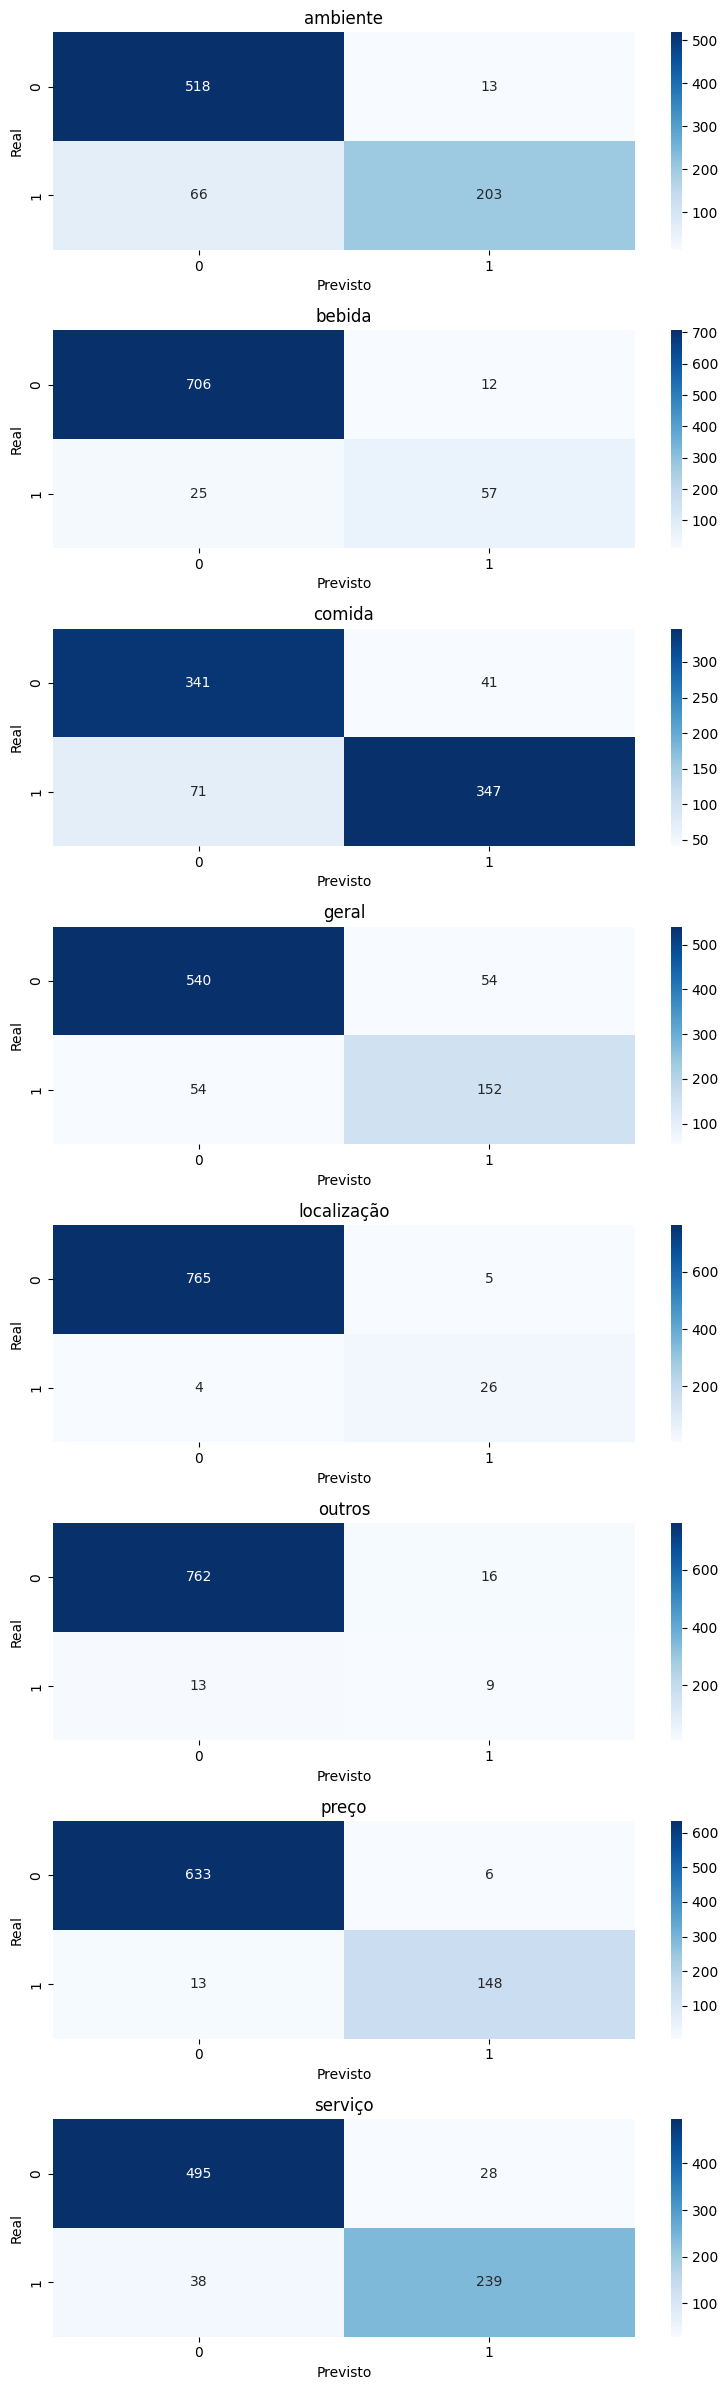

In [36]:
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# define as categorias correspondentes aos rótulos
category_id_df = pd.DataFrame({'categoria': labels, 'id': range(len(labels))})

# cria a matriz de confusão
conf_mat = multilabel_confusion_matrix(y_true, y_pred)

# plota as matrizes de confusão separadamente para cada categoria
fig, axes = plt.subplots(nrows=len(category_id_df), ncols=1, figsize=(8, 24))
for i, ax in enumerate(axes.flat):
    sns.heatmap(conf_mat[i], annot=True, fmt='d', ax=ax, cmap='Blues')
    ax.set(xlabel='Previsto', ylabel='Real', title=category_id_df.iloc[i]['categoria'])
plt.tight_layout()
plt.show()



## 2° Fold

In [37]:
# Carregar dados tabulares em um objeto Dataset do PyTorch e dividir o dataset
df = pd.concat([df_fold1, df_fold3, df_fold4, df_fold5])
train_data = TabularDataset(df)
test_data = TabularDataset(df_fold2)

In [38]:
# Criar e treinar modelo
multi_predictor = MultilabelPredictor(labels=labels, problem_types=problem_types, eval_metrics=eval_metrics)
multi_predictor.fit(train_data, time_limit=600, presets='best_quality')

No path specified. Models will be saved in: "AutogluonModels/ag-20230428_073544/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20230428_073544/Predictor_ambiente/"
AutoGluon Version:  0.7.0
Python Version:     3.10.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Sat Dec 10 16:00:40 UTC 2022
Train Data Rows:    3200
Train Data Columns: 1
Label Column: ambiente
Preprocessing data ...
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    11857.2 MB
	Train Data (Original)  Memory Usage: 0.5 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes 

Fitting TabularPredictor for label: ambiente ...


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 231
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['sentenca']
		('int', ['binned', 'text_special']) :   7 | ['sentenca.char_count', 'sentenca.word_count', 'sentenca.capital_ratio', 'sentenca.lower_ratio', 'sentenca.digit_ratio', ...]
		('int', ['text_ngram'])             

Fitting TabularPredictor for label: bebida ...


		Fitting AsTypeFeatureGenerator...
			Note: Converting 1 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 231
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 1 | ['ambiente']
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['sentenca']
		('int', ['binned', 'text_special']) :   7 | ['sentenca.char_cou

Fitting TabularPredictor for label: comida ...


			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 231
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 2 | ['ambiente', 'bebida']
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['sentenca']
		('int', ['binned', 'text_special']) :   7 | ['sentenca.char_count', 'sentenca.word_count', 'sentenca.capital_ratio', 'sentenca.lower_ratio', 'sentenca.digit_ratio', ...]
		('int', ['bool'])                   :   2 | ['ambiente', 'bebida']
		('int', ['text_ngram'])             : 232 | ['__nlp__.acessível', '__nlp__.aconchegante'

Fitting TabularPredictor for label: geral ...


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 3 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 231
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 3 | ['ambiente', 'bebida', 'comida']
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['sentenca']
		('int', ['binned', 'te

Fitting TabularPredictor for label: localização ...


		Fitting AsTypeFeatureGenerator...
			Note: Converting 4 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 231
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 4 | ['ambiente', 'bebida', 'comida', 'geral']
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['sentenca']
		('int', ['binned', 'text_special']

Fitting TabularPredictor for label: outros ...


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 5 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 231
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 5 | ['ambiente', 'bebida', 'comida', 'geral', 'localização']
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['sentenca']


Fitting TabularPredictor for label: preço ...


			Note: Converting 6 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 231
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 6 | ['ambiente', 'bebida', 'comida', 'geral', 'localização', ...]
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['sentenca']
		('int', ['binned', 'text_special']) :   7 | ['sent

Fitting TabularPredictor for label: serviço ...


	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 231
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 7 | ['ambiente', 'bebida', 'comida', 'geral', 'localização', ...]
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['sentenca']
		('int', ['binned', 'text_special']) :   7 | ['sentenca.char_count', 'sentenca.word_count', 'sentenca.capital_ratio', 'sentenca.lower_ratio', 'sentenca.digit_ratio', ...]
		('int', ['bool'])    

MultilabelPredictor saved to disk. Load with: MultilabelPredictor.load('AutogluonModels/ag-20230428_073544/')


In [39]:
# Teste do modelo
predictions = multi_predictor.predict(test_data)

Predicting with TabularPredictor for label: ambiente ...
Predicting with TabularPredictor for label: bebida ...
Predicting with TabularPredictor for label: comida ...
Predicting with TabularPredictor for label: geral ...
Predicting with TabularPredictor for label: localização ...
Predicting with TabularPredictor for label: outros ...
Predicting with TabularPredictor for label: preço ...
Predicting with TabularPredictor for label: serviço ...


### Resultados

In [40]:
from sklearn.metrics import f1_score

# Resultados
predictions_df=pd.DataFrame(predictions) 
y_pred = predictions_df.values # Obter as previsões
y_true = test_data.drop('sentenca', axis=1).values # Obter os rótulos reais dos dados de teste

accuracy = accuracy_score(y_true, y_pred)
f1_score_macro = f1_score(y_true, y_pred, average='macro')
precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')
f1_score_micro = f1_score(y_true, y_pred, average='micro')
precision_micro = precision_score(y_true, y_pred, average='micro')
recall_micro = recall_score(y_true, y_pred, average='micro')

# Adicionar valores das métricas para lista
accuracies.append(accuracy)
f1_score_list_macro.append(f1_score_macro)
precision_list_macro.append(precision_macro)
recall_list_macro.append(recall_macro)
f1_score_list_micro.append(f1_score_micro)
precision_list_micro.append(precision_micro)
recall_list_micro.append(recall_micro)

print("Acurácia do 2° Fold:", accuracy)
print("F1 Score Macro do 2° Fold:", f1_score_macro)
print("Precisão Macro do 2° Fold:", precision_macro)
print("Revocação Macro do 2° Fold:", recall_macro)
print("F1 Score Micro do 2° Fold:", f1_score_micro)
print("Precisão Micro do 2° Fold:", precision_micro)
print("Revocação Micro do 2° Fold:", recall_micro)

Acurácia do 2° Fold: 0.605
F1 Score Macro do 2° Fold: 0.7521876165499772
Precisão Macro do 2° Fold: 0.788987517628855
Revocação Macro do 2° Fold: 0.7245413696427623
F1 Score Micro do 2° Fold: 0.8258527827648116
Precisão Micro do 2° Fold: 0.8588498879761016
Revocação Micro do 2° Fold: 0.7952973720608575


In [41]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Calcular as métricas para cada rótulo separadamente
metrics_by_label = {}
for i, label in enumerate(labels):
    y_true_label = y_true[:, i] # Rótulos reais da classe correspondente ao label
    y_pred_label = y_pred[:, i] # Previsões da classe correspondente ao label
    accuracy = accuracy_score(y_true_label, y_pred_label)
    f1 = f1_score(y_true_label, y_pred_label)
    precision = precision_score(y_true_label, y_pred_label)
    recall = recall_score(y_true_label, y_pred_label)
    metrics_by_label[label] = {'accuracy': accuracy, 'f1_score': f1, 'precision': precision, 'recall': recall}

# Imprimir as métricas para cada rótulo
for label, metrics in metrics_by_label.items():
    print(f'Métricas para o rótulo {label}:')
    print(f'Acurácia: {metrics["accuracy"]:.4f}')
    print(f'F1-Score: {metrics["f1_score"]:.4f}')
    print(f'Precisão: {metrics["precision"]:.4f}')
    print(f'Revocação: {metrics["recall"]:.4f}')
    print('-----------------------------------')


Métricas para o rótulo ambiente:
Acurácia: 0.9150
F1-Score: 0.8489
Precisão: 0.9139
Revocação: 0.7925
-----------------------------------
Métricas para o rótulo bebida:
Acurácia: 0.9513
F1-Score: 0.6777
Precisão: 0.8367
Revocação: 0.5694
-----------------------------------
Métricas para o rótulo comida:
Acurácia: 0.8812
F1-Score: 0.8799
Precisão: 0.8923
Revocação: 0.8678
-----------------------------------
Métricas para o rótulo geral:
Acurácia: 0.8313
F1-Score: 0.7007
Precisão: 0.7596
Revocação: 0.6502
-----------------------------------
Métricas para o rótulo localização:
Acurácia: 0.9875
F1-Score: 0.8529
Precisão: 0.8286
Revocação: 0.8788
-----------------------------------
Métricas para o rótulo outros:
Acurácia: 0.9550
F1-Score: 0.2800
Precisão: 0.2692
Revocação: 0.2917
-----------------------------------
Métricas para o rótulo preço:
Acurácia: 0.9688
F1-Score: 0.9147
Precisão: 0.9504
Revocação: 0.8816
-----------------------------------
Métricas para o rótulo serviço:
Acurácia: 0

### Matriz de Confusão

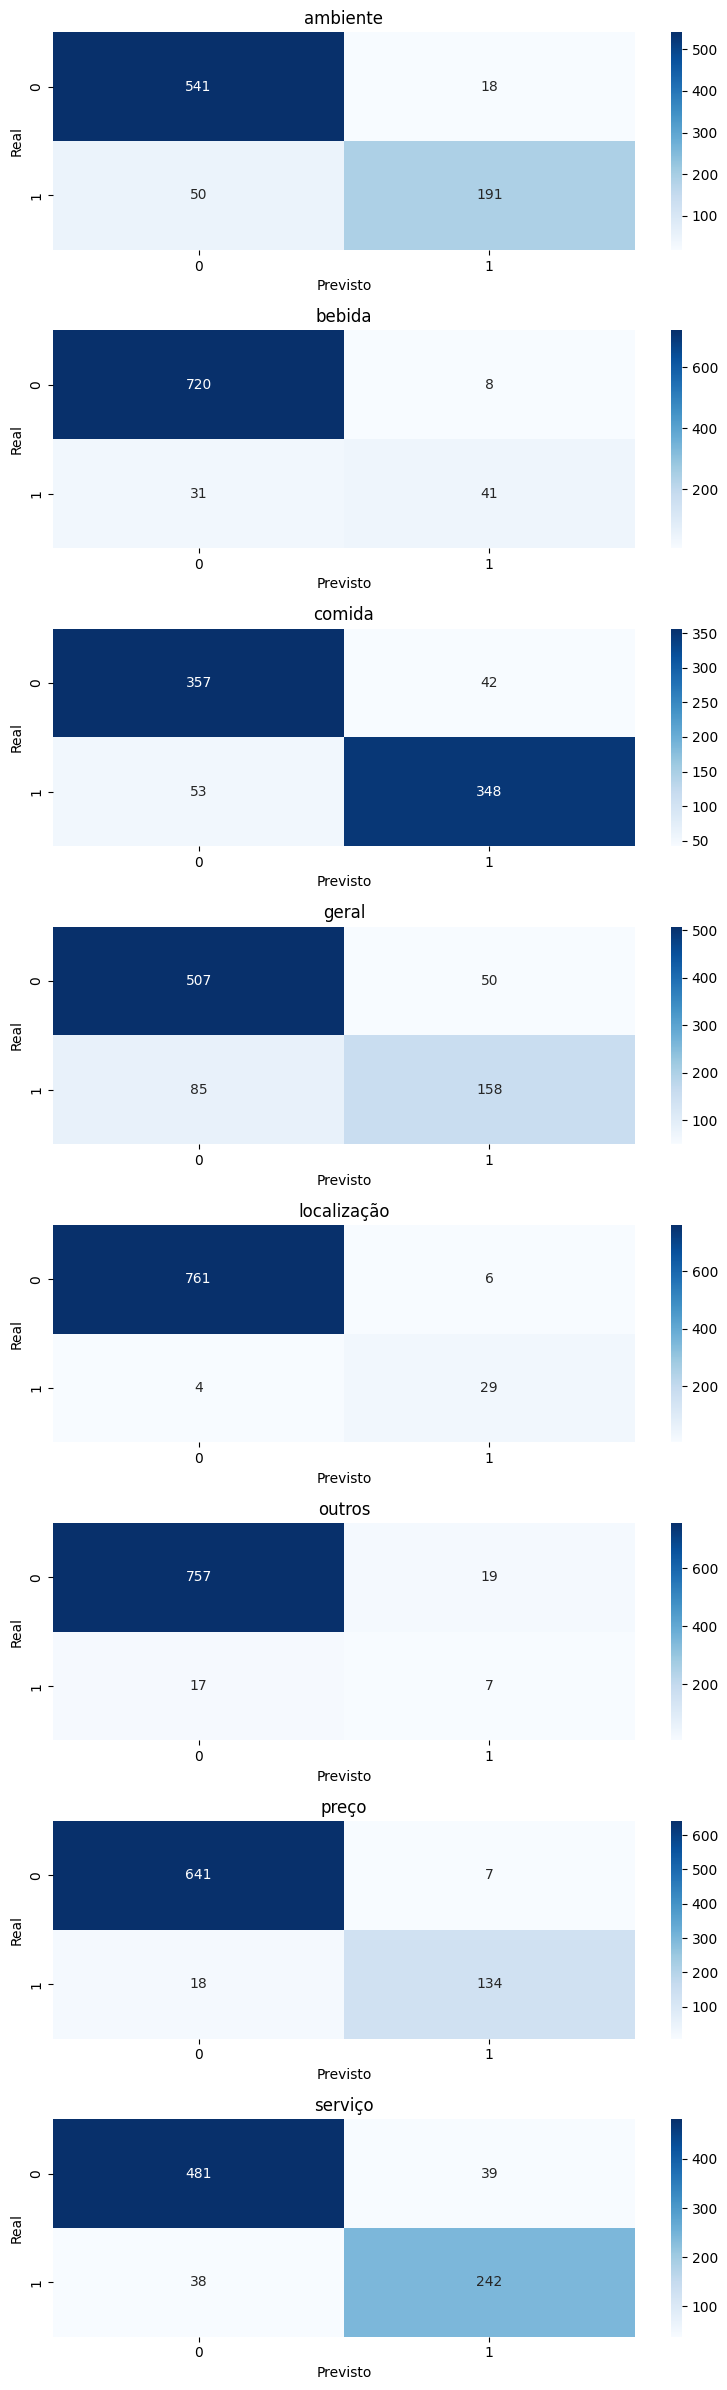

In [42]:
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# define as categorias correspondentes aos rótulos
category_id_df = pd.DataFrame({'categoria': labels, 'id': range(len(labels))})

# cria a matriz de confusão
conf_mat = multilabel_confusion_matrix(y_true, y_pred)

# plota as matrizes de confusão separadamente para cada categoria
fig, axes = plt.subplots(nrows=len(category_id_df), ncols=1, figsize=(8, 24))
for i, ax in enumerate(axes.flat):
    sns.heatmap(conf_mat[i], annot=True, fmt='d', ax=ax, cmap='Blues')
    ax.set(xlabel='Previsto', ylabel='Real', title=category_id_df.iloc[i]['categoria'])
plt.tight_layout()
plt.show()



## 3° Fold

In [43]:
# Carregar dados tabulares em um objeto Dataset do PyTorch e dividir o dataset
df = pd.concat([df_fold1, df_fold2, df_fold4, df_fold5])
train_data = TabularDataset(df)
test_data = TabularDataset(df_fold3)

In [44]:
# Criar e treinar modelo
multi_predictor = MultilabelPredictor(labels=labels, problem_types=problem_types, eval_metrics=eval_metrics)
multi_predictor.fit(train_data, time_limit=600, presets='best_quality')

No path specified. Models will be saved in: "AutogluonModels/ag-20230428_084656/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20230428_084656/Predictor_ambiente/"
AutoGluon Version:  0.7.0
Python Version:     3.10.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Sat Dec 10 16:00:40 UTC 2022
Train Data Rows:    3200
Train Data Columns: 1
Label Column: ambiente
Preprocessing data ...
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    11450.22 MB
	Train Data (Original)  Memory Usage: 0.73 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtype

Fitting TabularPredictor for label: ambiente ...


			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 231
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['sentenca']
		('int', ['binned', 'text_special']) :   7 | ['sentenca.char_count', 'sentenca.word_count', 'sentenca.capital_ratio', 'sentenca.lower_ratio', 'sentenca.digit_ratio', ...]
		('int', ['text_ngram'])             : 232 | ['__nlp__.acessível', '__nlp__.aconchegante', '__nlp__.agradável', '__nlp__.ainda', '__nlp__.almoço', ...]
	0.8s = Fit runtime
	1 features in original data used to g

Fitting TabularPredictor for label: bebida ...


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 1 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 231
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 1 | ['ambiente']
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['sentenca']
		('int', ['binned', 'text_special']) :   7 

Fitting TabularPredictor for label: comida ...


			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 231
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 2 | ['ambiente', 'bebida']
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['sentenca']
		('int', ['binned', 'text_special']) :   7 | ['sentenca.char_count', 'sentenca.word_count', 'sentenca.capital_ratio', 'sentenca.lower_ratio', 'sentenca.digit_ratio', ...]
		('int', ['bool'])                   :   2 | ['ambiente', 'bebida']
		('int', ['text_ngram'])             : 232 | ['__nlp__.acessível', '__nlp__.aconchegante'

Fitting TabularPredictor for label: geral ...


		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 231
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 3 | ['ambiente', 'bebida', 'comida']
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['sentenca']
		('int', ['binned', 'text_special']) :   7 | ['sentenca.char_count', 'sentenca.word_count', 'sentenca.capital_ratio', 'sentenca.lower_ratio', 'sentenca.digit_ratio', ...]
		('int', ['bool'])                   :   3 | ['ambiente', 'bebida', 'comida']
		('int', ['text_ngram'])       

Fitting TabularPredictor for label: localização ...


			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 231
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 4 | ['ambiente', 'bebida', 'comida', 'geral']
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['sentenca']
		('int', ['binned', 'text_special']) :   7 | ['sentenca.char_count', 'sentenca.word_count', 'sentenca.capital_ratio', 'sentenca.lower_ratio', 'sentenca.digit_ratio', ...]
		('int', ['bool'])                   :   4 | ['ambiente', 'bebida', 'comida', 'geral']
		('int', ['text_ngram'])             : 232 | ['__nl

Fitting TabularPredictor for label: outros ...


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 5 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 231
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 5 | ['ambiente', 'bebida', 'comida', 'geral', 'localização']
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['sentenca']


Fitting TabularPredictor for label: preço ...


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 6 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 231
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 6 | ['ambiente', 'bebida', 'comida', 'geral', 'localização', ...]
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['senten

Fitting TabularPredictor for label: serviço ...


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 7 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 231
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 7 | ['ambiente', 'bebida', 'comida', 'geral', 'localização', ...]
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['senten

MultilabelPredictor saved to disk. Load with: MultilabelPredictor.load('AutogluonModels/ag-20230428_084656/')


In [45]:
# Teste do modelo
predictions = multi_predictor.predict(test_data)

Predicting with TabularPredictor for label: ambiente ...
Predicting with TabularPredictor for label: bebida ...
Predicting with TabularPredictor for label: comida ...
Predicting with TabularPredictor for label: geral ...
Predicting with TabularPredictor for label: localização ...
Predicting with TabularPredictor for label: outros ...
Predicting with TabularPredictor for label: preço ...
Predicting with TabularPredictor for label: serviço ...


### Resultados

In [46]:
from sklearn.metrics import f1_score

# Resultados
predictions_df=pd.DataFrame(predictions) 
y_pred = predictions_df.values # Obter as previsões
y_true = test_data.drop('sentenca', axis=1).values # Obter os rótulos reais dos dados de teste

accuracy = accuracy_score(y_true, y_pred)
f1_score_macro = f1_score(y_true, y_pred, average='macro')
precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')
f1_score_micro = f1_score(y_true, y_pred, average='micro')
precision_micro = precision_score(y_true, y_pred, average='micro')
recall_micro = recall_score(y_true, y_pred, average='micro')

# Adicionar valores das métricas para lista
accuracies.append(accuracy)
f1_score_list_macro.append(f1_score_macro)
precision_list_macro.append(precision_macro)
recall_list_macro.append(recall_macro)
f1_score_list_micro.append(f1_score_micro)
precision_list_micro.append(precision_micro)
recall_list_micro.append(recall_micro)

print("Acurácia do 3° Fold:", accuracy)
print("F1 Score Macro do 3° Fold:", f1_score_macro)
print("Precisão Macro do 3° Fold:", precision_macro)
print("Revocação Macro do 3° Fold:", recall_macro)
print("F1 Score Micro do 3° Fold:", f1_score_micro)
print("Precisão Micro do 3° Fold:", precision_micro)
print("Revocação Micro do 3° Fold:", recall_micro)

Acurácia do 3° Fold: 0.61875
F1 Score Macro do 3° Fold: 0.7790275230890733
Precisão Macro do 3° Fold: 0.8287218469260549
Revocação Macro do 3° Fold: 0.7404404426070172
F1 Score Micro do 3° Fold: 0.8408698653779771
Precisão Micro do 3° Fold: 0.877521613832853
Revocação Micro do 3° Fold: 0.8071570576540755


In [47]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Calcular as métricas para cada rótulo separadamente
metrics_by_label = {}
for i, label in enumerate(labels):
    y_true_label = y_true[:, i] # Rótulos reais da classe correspondente ao label
    y_pred_label = y_pred[:, i] # Previsões da classe correspondente ao label
    accuracy = accuracy_score(y_true_label, y_pred_label)
    f1 = f1_score(y_true_label, y_pred_label)
    precision = precision_score(y_true_label, y_pred_label)
    recall = recall_score(y_true_label, y_pred_label)
    metrics_by_label[label] = {'accuracy': accuracy, 'f1_score': f1, 'precision': precision, 'recall': recall}

# Imprimir as métricas para cada rótulo
for label, metrics in metrics_by_label.items():
    print(f'Métricas para o rótulo {label}:')
    print(f'Acurácia: {metrics["accuracy"]:.4f}')
    print(f'F1-Score: {metrics["f1_score"]:.4f}')
    print(f'Precisão: {metrics["precision"]:.4f}')
    print(f'Revocação: {metrics["recall"]:.4f}')
    print('-----------------------------------')


Métricas para o rótulo ambiente:
Acurácia: 0.9087
F1-Score: 0.8352
Precisão: 0.9343
Revocação: 0.7551
-----------------------------------
Métricas para o rótulo bebida:
Acurácia: 0.9500
F1-Score: 0.7143
Precisão: 0.8772
Revocação: 0.6024
-----------------------------------
Métricas para o rótulo comida:
Acurácia: 0.8775
F1-Score: 0.8819
Precisão: 0.9015
Revocação: 0.8632
-----------------------------------
Métricas para o rótulo geral:
Acurácia: 0.8450
F1-Score: 0.7449
Precisão: 0.7802
Revocação: 0.7126
-----------------------------------
Métricas para o rótulo localização:
Acurácia: 0.9875
F1-Score: 0.8889
Precisão: 0.9524
Revocação: 0.8333
-----------------------------------
Métricas para o rótulo outros:
Acurácia: 0.9600
F1-Score: 0.3600
Precisão: 0.3462
Revocação: 0.3750
-----------------------------------
Métricas para o rótulo preço:
Acurácia: 0.9650
F1-Score: 0.9085
Precisão: 0.9586
Revocação: 0.8634
-----------------------------------
Métricas para o rótulo serviço:
Acurácia: 0

### Matriz de Confusão

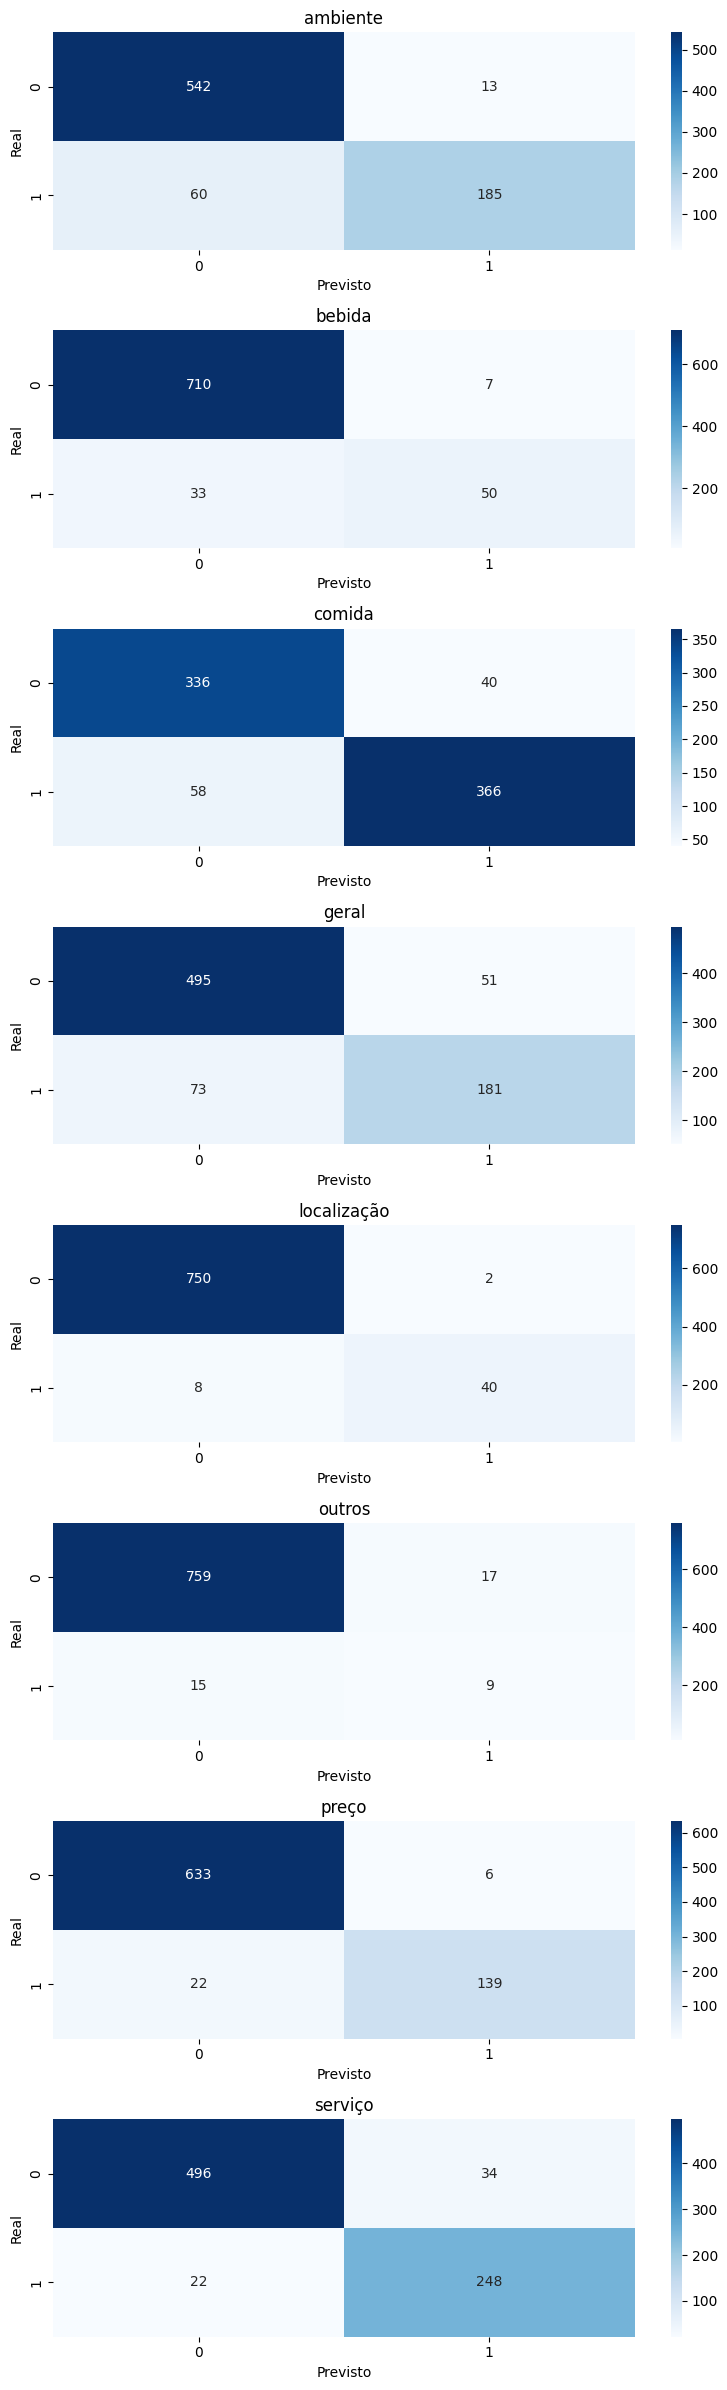

In [48]:
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# define as categorias correspondentes aos rótulos
category_id_df = pd.DataFrame({'categoria': labels, 'id': range(len(labels))})

# cria a matriz de confusão
conf_mat = multilabel_confusion_matrix(y_true, y_pred)

# plota as matrizes de confusão separadamente para cada categoria
fig, axes = plt.subplots(nrows=len(category_id_df), ncols=1, figsize=(8, 24))
for i, ax in enumerate(axes.flat):
    sns.heatmap(conf_mat[i], annot=True, fmt='d', ax=ax, cmap='Blues')
    ax.set(xlabel='Previsto', ylabel='Real', title=category_id_df.iloc[i]['categoria'])
plt.tight_layout()
plt.show()



## 4° Fold

In [7]:
# Carregar dados tabulares em um objeto Dataset do PyTorch e dividir o dataset
df = pd.concat([df_fold1, df_fold2, df_fold3, df_fold5])
train_data = TabularDataset(df)
test_data = TabularDataset(df_fold4)

In [8]:
# Criar e treinar modelo
multi_predictor = MultilabelPredictor(labels=labels, problem_types=problem_types, eval_metrics=eval_metrics)
multi_predictor.fit(train_data, time_limit=600, presets='best_quality')

Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20230428_160658/Predictor_ambiente/"
AutoGluon Version:  0.7.0
Python Version:     3.10.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Sat Dec 10 16:00:40 UTC 2022
Train Data Rows:    3200
Train Data Columns: 1
Label Column: ambiente
Preprocessing data ...
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    12593.68 MB
	Train Data (Original)  Memory Usage: 0.5 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 

Fitting TabularPredictor for label: ambiente ...


			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 222
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['sentenca']
		('int', ['binned', 'text_special']) :   7 | ['sentenca.char_count', 'sentenca.word_count', 'sentenca.capital_ratio', 'sentenca.lower_ratio', 'sentenca.digit_ratio', ...]
		('int', ['text_ngram'])             : 223 | ['__nlp__.acessível', '__nlp__.aconchegante', '__nlp__.agradável', '__nlp__.ainda', '__nlp__.almoço', ...]
	0.7s = Fit runtime
	1 features in original data used to g

Fitting TabularPredictor for label: bebida ...


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 1 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 222
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 1 | ['ambiente']
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['sentenca']
		('int', ['binned', 'text_special']) :   7 

Fitting TabularPredictor for label: comida ...


			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 222
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 2 | ['ambiente', 'bebida']
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['sentenca']
		('int', ['binned', 'text_special']) :   7 | ['sentenca.char_count', 'sentenca.word_count', 'sentenca.capital_ratio', 'sentenca.lower_ratio', 'sentenca.digit_ratio', ...]
		('int', ['bool'])                   :   2 | ['ambiente', 'bebida']
		('int', ['text_ngram'])             : 223 | ['__nlp__.acessível', '__nlp__.aconchegante', '__nlp__.agradável', '__nlp__.ainda', '__nlp__.almoço', ...]
	0.7s = Fit runtime
	3 features

Fitting TabularPredictor for label: geral ...


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 3 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 222
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 3 | ['ambiente', 'bebida', 'comida']
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['sentenca']
		('int', ['binned', 'te

Fitting TabularPredictor for label: localização ...


			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 222
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 4 | ['ambiente', 'bebida', 'comida', 'geral']
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['sentenca']
		('int', ['binned', 'text_special']) :   7 | ['sentenca.char_count', 'sentenca.word_count', 'sentenca.capital_ratio', 'sentenca.lower_ratio', 'sentenca.digit_ratio', ...]
		('int', ['bool'])                   :   4 | ['ambiente', 'bebida', 'comida', 'geral']
		('int', ['text_ngram'])             : 223 | ['__nl

Fitting TabularPredictor for label: outros ...


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 5 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 222
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 5 | ['ambiente', 'bebida', 'comida', 'geral', 'localização']
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['sentenca']


Fitting TabularPredictor for label: preço ...


			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 222
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 6 | ['ambiente', 'bebida', 'comida', 'geral', 'localização', ...]
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['sentenca']
		('int', ['binned', 'text_special']) :   7 | ['sentenca.char_count', 'sentenca.word_count', 'sentenca.capital_ratio', 'sentenca.lower_ratio', 'sentenca.digit_ratio', ...]
		('int', ['bool'])                   :   6 | ['ambiente', 'bebida', 'comida', 'geral', 'localização', ...]
		('int', ['

Fitting TabularPredictor for label: serviço ...


	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 222
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 7 | ['ambiente', 'bebida', 'comida', 'geral', 'localização', ...]
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['sentenca']
		('int', ['binned', 'text_special']) :   7 | ['sentenca.char_count', 'sentenca.word_count', 'sentenca.capital_ratio', 'sentenca.lower_ratio', 'sentenca.digit_ratio', ...]
		('int', ['bool'])    

MultilabelPredictor saved to disk. Load with: MultilabelPredictor.load('AutogluonModels/ag-20230428_160658/')


In [9]:
# Teste do modelo
predictions = multi_predictor.predict(test_data)

Predicting with TabularPredictor for label: ambiente ...
Predicting with TabularPredictor for label: bebida ...
Predicting with TabularPredictor for label: comida ...
Predicting with TabularPredictor for label: geral ...
Predicting with TabularPredictor for label: localização ...
Predicting with TabularPredictor for label: outros ...
Predicting with TabularPredictor for label: preço ...
Predicting with TabularPredictor for label: serviço ...


### Resultados

In [10]:
from sklearn.metrics import f1_score

# Resultados
predictions_df=pd.DataFrame(predictions) 
y_pred = predictions_df.values # Obter as previsões
y_true = test_data.drop('sentenca', axis=1).values # Obter os rótulos reais dos dados de teste

accuracy = accuracy_score(y_true, y_pred)
f1_score_macro = f1_score(y_true, y_pred, average='macro')
precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')
f1_score_micro = f1_score(y_true, y_pred, average='micro')
precision_micro = precision_score(y_true, y_pred, average='micro')
recall_micro = recall_score(y_true, y_pred, average='micro')

# Adicionar valores das métricas para lista
accuracies.append(accuracy)
f1_score_list_macro.append(f1_score_macro)
precision_list_macro.append(precision_macro)
recall_list_macro.append(recall_macro)
f1_score_list_micro.append(f1_score_micro)
precision_list_micro.append(precision_micro)
recall_list_micro.append(recall_micro)

print("Acurácia do 4° Fold:", accuracy)
print("F1 Score Macro do 4° Fold:", f1_score_macro)
print("Precisão Macro do 4° Fold:", precision_macro)
print("Revocação Macro do 4° Fold:", recall_macro)
print("F1 Score Micro do 4° Fold:", f1_score_micro)
print("Precisão Micro do 4° Fold:", precision_micro)
print("Revocação Micro do 4° Fold:", recall_micro)

Acurácia do 4° Fold: 0.6225
F1 Score Macro do 4° Fold: 0.7873442070676391
Precisão Macro do 4° Fold: 0.8380582595771104
Revocação Macro do 4° Fold: 0.7505527531928292
F1 Score Micro do 4° Fold: 0.840698869475848
Precisão Micro do 4° Fold: 0.8859205776173286
Revocação Micro do 4° Fold: 0.7998696219035202


In [11]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Calcular as métricas para cada rótulo separadamente
metrics_by_label = {}
for i, label in enumerate(labels):
    y_true_label = y_true[:, i] # Rótulos reais da classe correspondente ao label
    y_pred_label = y_pred[:, i] # Previsões da classe correspondente ao label
    accuracy = accuracy_score(y_true_label, y_pred_label)
    f1 = f1_score(y_true_label, y_pred_label)
    precision = precision_score(y_true_label, y_pred_label)
    recall = recall_score(y_true_label, y_pred_label)
    metrics_by_label[label] = {'accuracy': accuracy, 'f1_score': f1, 'precision': precision, 'recall': recall}

# Imprimir as métricas para cada rótulo
for label, metrics in metrics_by_label.items():
    print(f'Métricas para o rótulo {label}:')
    print(f'Acurácia: {metrics["accuracy"]:.4f}')
    print(f'F1-Score: {metrics["f1_score"]:.4f}')
    print(f'Precisão: {metrics["precision"]:.4f}')
    print(f'Revocação: {metrics["recall"]:.4f}')
    print('-----------------------------------')


Métricas para o rótulo ambiente:
Acurácia: 0.9087
F1-Score: 0.8450
Precisão: 0.9614
Revocação: 0.7538
-----------------------------------
Métricas para o rótulo bebida:
Acurácia: 0.9537
F1-Score: 0.7702
Precisão: 0.9118
Revocação: 0.6667
-----------------------------------
Métricas para o rótulo comida:
Acurácia: 0.8475
F1-Score: 0.8548
Precisão: 0.8778
Revocação: 0.8329
-----------------------------------
Métricas para o rótulo geral:
Acurácia: 0.8450
F1-Score: 0.7316
Precisão: 0.7824
Revocação: 0.6870
-----------------------------------
Métricas para o rótulo localização:
Acurácia: 0.9875
F1-Score: 0.8864
Precisão: 0.9750
Revocação: 0.8125
-----------------------------------
Métricas para o rótulo outros:
Acurácia: 0.9688
F1-Score: 0.3590
Precisão: 0.3043
Revocação: 0.4375
-----------------------------------
Métricas para o rótulo preço:
Acurácia: 0.9862
F1-Score: 0.9603
Precisão: 0.9925
Revocação: 0.9301
-----------------------------------
Métricas para o rótulo serviço:
Acurácia: 0

### Matriz de Confusão

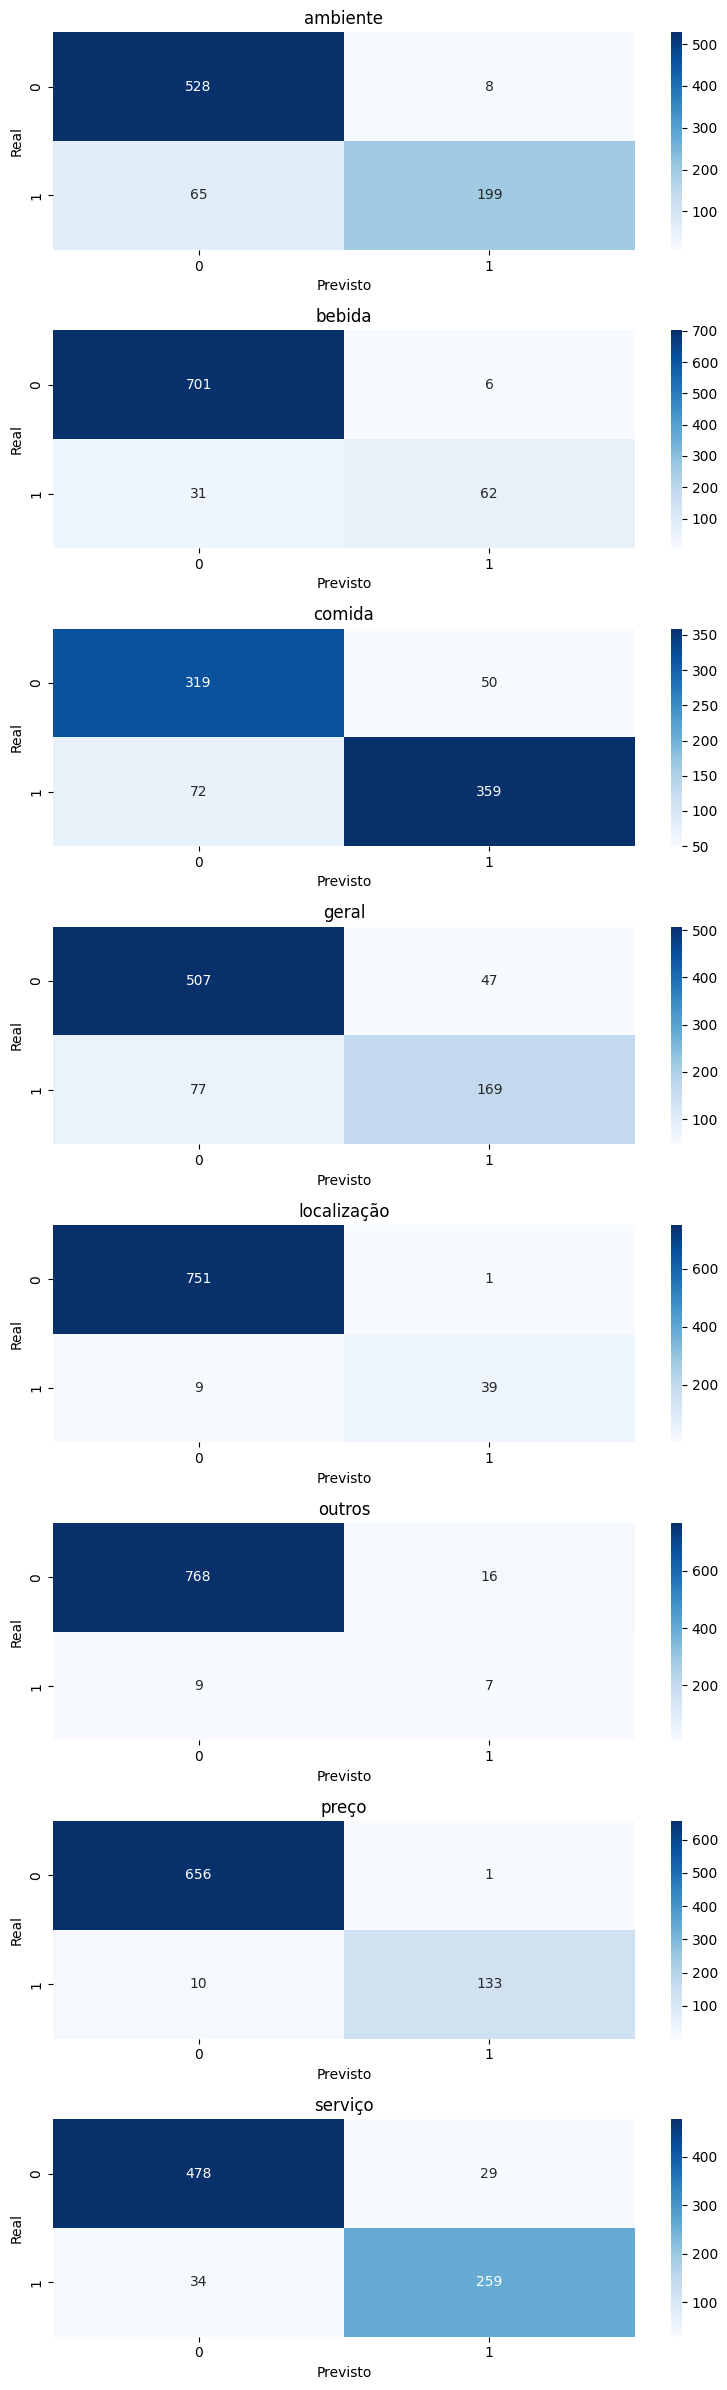

In [12]:
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# define as categorias correspondentes aos rótulos
category_id_df = pd.DataFrame({'categoria': labels, 'id': range(len(labels))})

# cria a matriz de confusão
conf_mat = multilabel_confusion_matrix(y_true, y_pred)

# plota as matrizes de confusão separadamente para cada categoria
fig, axes = plt.subplots(nrows=len(category_id_df), ncols=1, figsize=(8, 24))
for i, ax in enumerate(axes.flat):
    sns.heatmap(conf_mat[i], annot=True, fmt='d', ax=ax, cmap='Blues')
    ax.set(xlabel='Previsto', ylabel='Real', title=category_id_df.iloc[i]['categoria'])
plt.tight_layout()
plt.show()



## 5° Fold

In [13]:
# Carregar dados tabulares em um objeto Dataset do PyTorch e dividir o dataset
df = pd.concat([df_fold1, df_fold2, df_fold3, df_fold4])
train_data = TabularDataset(df)
test_data = TabularDataset(df_fold5)

In [14]:
# Criar e treinar modelo
multi_predictor = MultilabelPredictor(labels=labels, problem_types=problem_types, eval_metrics=eval_metrics)
multi_predictor.fit(train_data, time_limit=600, presets='best_quality')

No path specified. Models will be saved in: "AutogluonModels/ag-20230428_171808/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20230428_171808/Predictor_ambiente/"
AutoGluon Version:  0.7.0
Python Version:     3.10.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Sat Dec 10 16:00:40 UTC 2022
Train Data Rows:    3200
Train Data Columns: 1
Label Column: ambiente
Preprocessing data ...
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    11489.22 MB
	Train Data (Original)  Memory Usage: 0.73 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtype

Fitting TabularPredictor for label: ambiente ...


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 231
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['sentenca']
		('int', ['binned', 'text_special']) :   7 | ['sentenca.char_count', 'sentenca.word_count', 'sentenca.capital_ratio', 'sentenca.lower_ratio', 'sentenca.digit_ratio', ...]
		('int', ['text_ngram'])             

Fitting TabularPredictor for label: bebida ...


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 1 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 231
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 1 | ['ambiente']
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['sentenca']
		('int', ['binned', 'text_special']) :   7 

Fitting TabularPredictor for label: comida ...


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 2 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 231
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 2 | ['ambiente', 'bebida']
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['sentenca']
		('int', ['binned', 'text_special

Fitting TabularPredictor for label: geral ...


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 3 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 231
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 3 | ['ambiente', 'bebida', 'comida']
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['sentenca']
		('int', ['binned', 'te

Fitting TabularPredictor for label: localização ...


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 4 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 231
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 4 | ['ambiente', 'bebida', 'comida', 'geral']
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['sentenca']
		('int', ['bin

Fitting TabularPredictor for label: outros ...


			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 231
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 5 | ['ambiente', 'bebida', 'comida', 'geral', 'localização']
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['sentenca']
		('int', ['binned', 'text_special']) :   7 | ['sentenca.char_count', 'sentenca.word_count', 'sentenca.capital_ratio', 'sentenca.lower_ratio', 'sentenca.digit_ratio', ...]
		('int', ['bool'])                   :   5 | ['ambiente', 'bebida', 'comida', 'geral', 'localização']
		('int', ['text_ngram'])             : 232 | ['__nlp__.acessível', '__nlp__.aconchegante', '__nlp__.agradável', '__

Fitting TabularPredictor for label: preço ...


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 6 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 231
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 6 | ['ambiente', 'bebida', 'comida', 'geral', 'localização', ...]
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['senten

Fitting TabularPredictor for label: serviço ...


	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['sentenca']
			CountVectorizer fit with vocabulary size = 231
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', [])          : 7 | ['ambiente', 'bebida', 'comida', 'geral', 'localização', ...]
		('object', ['text']) : 1 | ['sentenca']
	Types of features in processed data (raw dtype, special dtypes):
		('category', ['text_as_category'])  :   1 | ['sentenca']
		('int', ['binned', 'text_special']) :   7 | ['sentenca.char_count', 'sentenca.word_count', 'sentenca.capital_ratio', 'sentenca.lower_ratio', 'sentenca.digit_ratio', ...]
		('int', ['bool'])    

MultilabelPredictor saved to disk. Load with: MultilabelPredictor.load('AutogluonModels/ag-20230428_171808/')


In [15]:
# Teste do modelo
predictions = multi_predictor.predict(test_data)

Predicting with TabularPredictor for label: ambiente ...
Predicting with TabularPredictor for label: bebida ...
Predicting with TabularPredictor for label: comida ...
Predicting with TabularPredictor for label: geral ...
Predicting with TabularPredictor for label: localização ...
Predicting with TabularPredictor for label: outros ...
Predicting with TabularPredictor for label: preço ...
Predicting with TabularPredictor for label: serviço ...


### Resultados

In [16]:
from sklearn.metrics import f1_score

# Resultados
predictions_df=pd.DataFrame(predictions) 
y_pred = predictions_df.values # Obter as previsões
y_true = test_data.drop('sentenca', axis=1).values # Obter os rótulos reais dos dados de teste

accuracy = accuracy_score(y_true, y_pred)
f1_score_macro = f1_score(y_true, y_pred, average='macro')
precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')
f1_score_micro = f1_score(y_true, y_pred, average='micro')
precision_micro = precision_score(y_true, y_pred, average='micro')
recall_micro = recall_score(y_true, y_pred, average='micro')

# Adicionar valores das métricas para lista
accuracies.append(accuracy)
f1_score_list_macro.append(f1_score_macro)
precision_list_macro.append(precision_macro)
recall_list_macro.append(recall_macro)
f1_score_list_micro.append(f1_score_micro)
precision_list_micro.append(precision_micro)
recall_list_micro.append(recall_micro)

print("Acurácia do 5° Fold:", accuracy)
print("F1 Score Macro do 5° Fold:", f1_score_macro)
print("Precisão Macro do 5° Fold:", precision_macro)
print("Revocação Macro do 5° Fold:", recall_macro)
print("F1 Score Micro do 5° Fold:", f1_score_micro)
print("Precisão Micro do 5° Fold:", precision_micro)
print("Revocação Micro do 5° Fold:", recall_micro)

Acurácia do 5° Fold: 0.61875
F1 Score Macro do 5° Fold: 0.7423438787356937
Precisão Macro do 5° Fold: 0.8038135669810988
Revocação Macro do 5° Fold: 0.7015812101018517
F1 Score Micro do 5° Fold: 0.8356741573033707
Precisão Micro do 5° Fold: 0.875
Revocação Micro do 5° Fold: 0.7997311827956989


In [17]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Calcular as métricas para cada rótulo separadamente
metrics_by_label = {}
for i, label in enumerate(labels):
    y_true_label = y_true[:, i] # Rótulos reais da classe correspondente ao label
    y_pred_label = y_pred[:, i] # Previsões da classe correspondente ao label
    accuracy = accuracy_score(y_true_label, y_pred_label)
    f1 = f1_score(y_true_label, y_pred_label)
    precision = precision_score(y_true_label, y_pred_label)
    recall = recall_score(y_true_label, y_pred_label)
    metrics_by_label[label] = {'accuracy': accuracy, 'f1_score': f1, 'precision': precision, 'recall': recall}

# Imprimir as métricas para cada rótulo
for label, metrics in metrics_by_label.items():
    print(f'Métricas para o rótulo {label}:')
    print(f'Acurácia: {metrics["accuracy"]:.4f}')
    print(f'F1-Score: {metrics["f1_score"]:.4f}')
    print(f'Precisão: {metrics["precision"]:.4f}')
    print(f'Revocação: {metrics["recall"]:.4f}')
    print('-----------------------------------')


Métricas para o rótulo ambiente:
Acurácia: 0.9237
F1-Score: 0.8598
Precisão: 0.9492
Revocação: 0.7857
-----------------------------------
Métricas para o rótulo bebida:
Acurácia: 0.9475
F1-Score: 0.6500
Precisão: 0.8478
Revocação: 0.5270
-----------------------------------
Métricas para o rótulo comida:
Acurácia: 0.8712
F1-Score: 0.8714
Precisão: 0.9089
Revocação: 0.8369
-----------------------------------
Métricas para o rótulo geral:
Acurácia: 0.8512
F1-Score: 0.7526
Precisão: 0.7637
Revocação: 0.7418
-----------------------------------
Métricas para o rótulo localização:
Acurácia: 0.9775
F1-Score: 0.7500
Precisão: 0.9000
Revocação: 0.6429
-----------------------------------
Métricas para o rótulo outros:
Acurácia: 0.9500
F1-Score: 0.2308
Precisão: 0.1875
Revocação: 0.3000
-----------------------------------
Métricas para o rótulo preço:
Acurácia: 0.9762
F1-Score: 0.9408
Precisão: 0.9805
Revocação: 0.9042
-----------------------------------
Métricas para o rótulo serviço:
Acurácia: 0

### Matriz de Confusão

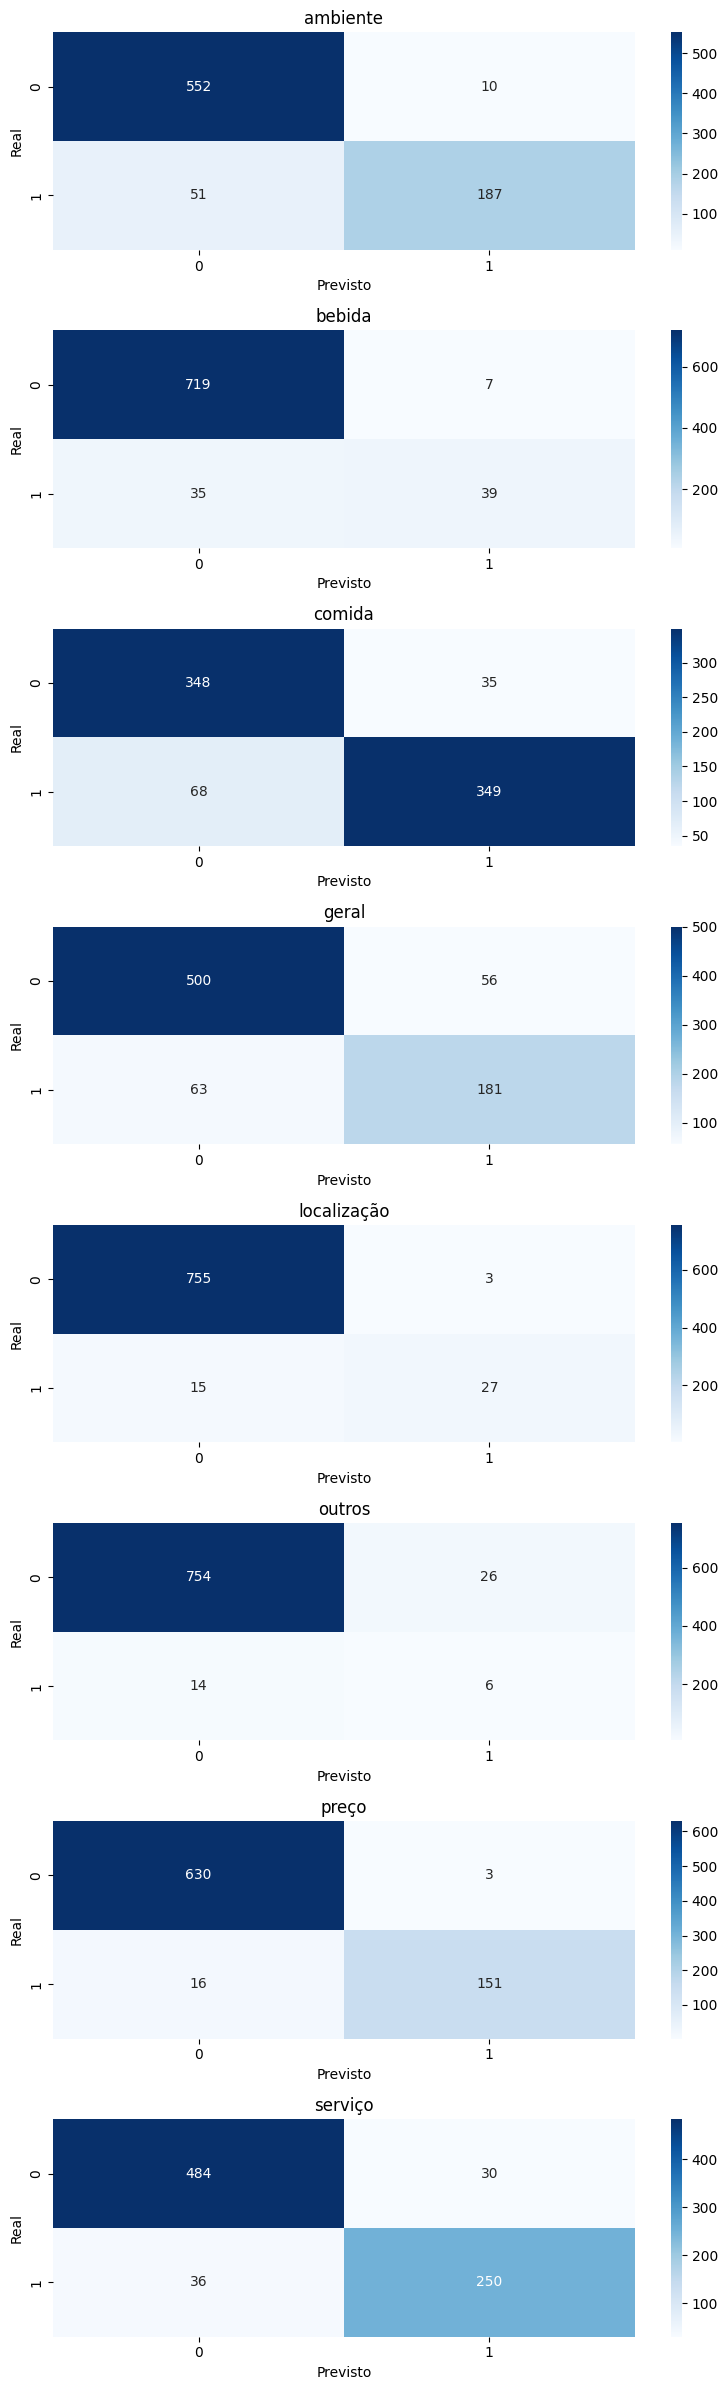

In [18]:
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# define as categorias correspondentes aos rótulos
category_id_df = pd.DataFrame({'categoria': labels, 'id': range(len(labels))})

# cria a matriz de confusão
conf_mat = multilabel_confusion_matrix(y_true, y_pred)

# plota as matrizes de confusão separadamente para cada categoria
fig, axes = plt.subplots(nrows=len(category_id_df), ncols=1, figsize=(8, 24))
for i, ax in enumerate(axes.flat):
    sns.heatmap(conf_mat[i], annot=True, fmt='d', ax=ax, cmap='Blues')
    ax.set(xlabel='Previsto', ylabel='Real', title=category_id_df.iloc[i]['categoria'])
plt.tight_layout()
plt.show()



## Resultado Geral do AutoGluon com Validação Cruzada

In [19]:
a= 0.61375
b= 0.7805979126050349
c= 0.8066219338142889
d= 0.7594505660408967
e= 0.837291740517547
f= 0.8709439528023599
g= 0.8061433447098976

accuracies.append(a)
f1_score_list_macro.append(b)
precision_list_macro.append(c)
recall_list_macro.append(d)
f1_score_list_micro.append(e)
precision_list_micro.append(f)
recall_list_micro.append(g)

a= 0.605
b= 0.7521876165499772
c= 0.788987517628855
d= 0.7245413696427623
e= 0.8258527827648116
f= 0.8588498879761016
g= 0.7952973720608575

accuracies.append(a)
f1_score_list_macro.append(b)
precision_list_macro.append(c)
recall_list_macro.append(d)
f1_score_list_micro.append(e)
precision_list_micro.append(f)
recall_list_micro.append(g)

a= 0.61875
b= 0.7790275230890733
c= 0.8287218469260549
d= 0.7404404426070172
e= 0.8408698653779771
f= 0.877521613832853
g= 0.8071570576540755

accuracies.append(a)
f1_score_list_macro.append(b)
precision_list_macro.append(c)
recall_list_macro.append(d)
f1_score_list_micro.append(e)
precision_list_micro.append(f)
recall_list_micro.append(g)

In [20]:
accuracies

[0.6225, 0.61875, 0.61375, 0.605, 0.61875]

In [21]:
# Imprimir as métricas médias obtidas nas 5 partições
print("Acurácia média:", sum(accuracies) / len(accuracies))
print("F1 Score Macro médio:", sum(f1_score_list_macro) / len(f1_score_list_macro))
print("Precisão Macro média:", sum(precision_list_macro) / len(precision_list_macro))
print("Revocação Macro média:", sum(recall_list_macro) / len(recall_list_macro))
print("F1 Score Micro médio:", sum(f1_score_list_micro) / len(f1_score_list_micro))
print("Precisão Micro média:", sum(precision_list_micro) / len(precision_list_micro))
print("Revocação Micro média:", sum(recall_list_micro) / len(recall_list_micro))

Acurácia média: 0.61575
F1 Score Macro médio: 0.7683002276094838
Precisão Macro média: 0.8132406249854818
Revocação Macro média: 0.7353132683170713
F1 Score Micro médio: 0.8360774830879109
Precisão Micro média: 0.8736472064457287
Revocação Micro média: 0.8016397158248099
